In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkConf
from os.path import expanduser, join, abspath
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.types import StructField
import numpy as np
import pandas as pd
import matplotlib.dates as mdate

In [2]:
warehouse_location = abspath('/user/hive/warehouse')

In [3]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .master("spark://app-13:7077") \
    .getOrCreate()
df = spark.read.format("CSV").option("header","true").\
option("timestampFormat ","yyyy-MM-dd'T'HH").\
schema("user_id int,item_id int,behavior_type int,user_geohash string,item_category int,create_time string").\
load("/user/hive/warehouse/test.db/tianchi/tianchi_mobile_recommend_train_user.csv") 
df.createOrReplaceTempView("taobao")

In [4]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [5]:
spark.sql("SELECT count(*) FROM taobao").show()

+--------+
|count(1)|
+--------+
|12256906|
+--------+



In [6]:
sqlDF = spark.sql("SELECT hour(to_timestamp(create_time)) as create_hour, count(*) as pbcf FROM taobao group by hour(to_timestamp(create_time)) order by hour(to_timestamp(create_time))")

In [7]:
sqlDF.cache()

DataFrame[create_hour: int, pbcf: bigint]

In [ ]:
sqlDF.show()

In [9]:
pbcfPandasDF = sqlDF.toPandas()

/hadoop/Anaconda/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


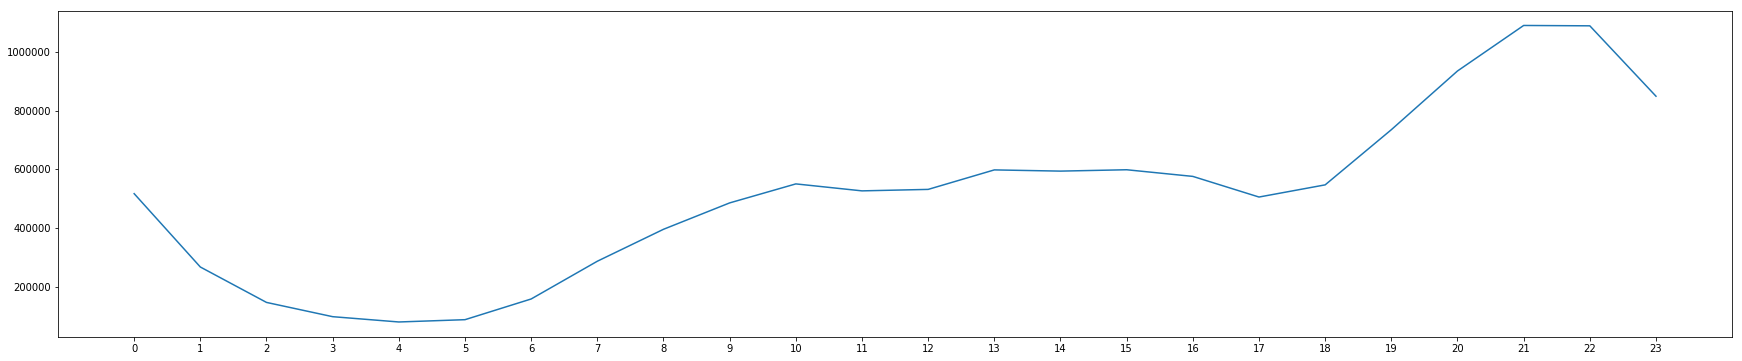

In [10]:
fig=plt.figure(figsize=(30,6))
ax=fig.add_subplot(1,1,1)
date_series=pbcfPandasDF['create_hour']
plt.xticks(date_series)
ax.plot(date_series,pbcfPandasDF.set_index('create_hour'))
plt.show()

In [12]:
spark.catalog.clearCache()